In [1]:
# Core
import numpy as np
import pandas as pd

# Tensorflow / ML
import tensorflow as tf

# Utility
import os

# Plotting
import matplotlib.pyplot as plt
import matplotlib as mpl
    
# Utility
import time

In [2]:
# Set visibible GPU
gpu_num: int = 1
os.environ['CUDA_VISIBLE_DEVICES']=f'{gpu_num}'

In [3]:
# Configure TF GPU growth
import kepler_sieve
from tf_utils import gpu_grow_memory, get_gpu_device
gpu_grow_memory(verbose=True)

Found 1 GPUs.  Setting memory growth = True.


In [4]:
# MSE Imports
from asteroid_search import load_fitted_elts, load_ztf_hits, append_fitted_elt, append_ztf_hit, file_name_model
from asteroid_element import load_ast_elt
from candidate_element import asteroid_elts, perturb_elts, random_elts, elts_add_mixture_params, elts_add_H
from random_elements import load_best_random_elts, make_ztf_ast
from ztf_ast import load_ztf_nearest_ast, calc_hit_freq
from ztf_element import load_ztf_batch, make_ztf_batch, ztf_score_by_elt, ztf_elt_summary
from asteroid_model import AsteroidPosition, AsteroidDirection, make_model_ast_pos
from asteroid_search_layers import CandidateElements, MixtureParameters, TrajectoryScore
from asteroid_search_model import AsteroidSearchModel
from asteroid_search_report import traj_diff
from nearest_asteroid import nearest_ast_elt_cart, nearest_ast_elt_cov, elt_q_norm
from element_eda import score_by_elt
from asteroid_dataframe import calc_ast_data, spline_ast_vec_df
from astro_utils import deg2dist, dist2deg, dist2sec

In [5]:
# Aliases
keras = tf.keras

# Constants
dtype = tf.float32
dtype_np = np.float32
space_dims = 3

In [6]:
# Set plot style variables
mpl.rcParams['figure.figsize'] = [16.0, 10.0]
mpl.rcParams['font.size'] = 16

## Review Fitted Elements

In [7]:
known_ast = False
min_hits = 8
max_res: float = 20.0

In [8]:
fitted_elts = load_fitted_elts(known_ast=known_ast, min_hits=8)
fitted_elts.hits = np.round(fitted_elts.hits)
fitted_elts.sort_values(['hits', 'R_sec'], ascending=[False, True], inplace=True)
best_element_id = fitted_elts.element_id.iloc[0]

In [10]:
is_good = fitted_elts.R_sec < max_res
good_elts = fitted_elts[is_good]

In [11]:
good_elts

,element_id,a,e,inc,Omega,omega,f,epoch,num_hits,R_sec,thresh_sec,log_like,hits,num_rows_close,timestamp
element_id,,,,,,,,,,,,,,,
170789,170789,2.735330,0.152867,0.403704,6.038029,3.016818,-3.443415,58600.0,9.997651,5.272874,336.844482,63.894360,10.0,13.0,2020-04-27 15:50:49.486473
178421,178421,3.159712,0.088905,0.153618,2.668798,4.773842,-0.463039,58600.0,10.988490,10.796460,502.733093,61.412579,10.0,19.0,2020-04-28 08:06:44.166954
44117,44117,2.935864,0.187419,0.124515,3.166528,1.230836,-3.122138,58600.0,9.990374,13.031281,863.441772,57.351826,10.0,29.0,2020-04-24 20:09:21.720375
3308,3308,3.026904,0.119945,0.129432,3.903342,4.525802,4.818909,58600.0,9.921326,5.803865,336.060303,59.502411,9.0,14.0,2020-04-23 22:58:22.891494
45801,45801,2.754677,0.047293,0.118126,3.139070,5.767782,-1.949476,58600.0,8.976903,12.320272,589.068054,50.120068,9.0,18.0,2020-04-24 20:53:59.991079
191915,191915,2.315446,0.192885,0.057156,2.130249,2.865086,-4.122024,58600.0,7.974357,13.703813,732.464905,37.517681,8.0,41.0,2020-04-28 07:12:19.739871
113970,113970,2.897023,0.068932,0.209250,5.663728,3.868474,4.450756,58600.0,7.983499,14.468097,690.245483,46.563499,8.0,14.0,2020-04-26 10:51:54.459207
96507,96507,2.820178,0.069025,0.080228,2.221972,0.960994,-2.630978,58600.0,9.045378,18.369638,750.331299,42.609283,8.0,28.0,2020-04-26 01:52:35.212885
50775,50775,2.374712,0.100280,0.165483,4.280114,5.955170,2.995417,58600.0,9.970323,19.354061,862.389160,47.708138,8.0,31.0,2020-04-24 23:35:22.881139


In [12]:
num_elts: int = good_elts.shape[0]
print(f'found {num_elts} good elements with at least {min_hits} hits and R_sec < {max_res} arc seconds.')

found 9 good elements with at least 8 hits and R_sec < 20.0 arc seconds.


In [13]:
# mean resolution
R_mean = np.mean(good_elts.R_sec)
R_geomean = np.exp(np.mean(np.log(good_elts.R_sec)))

In [74]:
# report resolution
print(f'Mean resolution   : {R_mean:6.2f} arc sec')
print(f'GeoMean resolution: {R_geomean:6.2f} arc sec')

Mean resolution   :  12.57 arc sec
GeoMean resolution:  11.58 arc sec


## Review ZTF Hits

In [14]:
ztf_hits = load_ztf_hits(known_ast=known_ast, display=True, min_hits=min_hits)

In [15]:
ztf_hits = ztf_hits.loc[good_elts.element_id]

In [68]:
ztf_hits

element_id   ztf_id         ObjectID          CandidateID  \
element_id ztf_id                                                               
3308       5571214        3308  5571214  b'ZTF17aaaqwwg'  1149113580315015023   
           5571215        3308  5571215  b'ZTF17aaaqwwg'  1149116801415015019   
           5573602        3308  5573602  b'ZTF17aaaqwwg'  1149129091415015026   
           5573603        3308  5573603  b'ZTF17aaaqwwg'  1149126845615015021   
           5574009        3308  5574009  b'ZTF17aaaqwwg'  1149128190315015031   
...                        ...      ...              ...                  ...   
178421     5573603      178421  5573603  b'ZTF17aaaqwwg'  1149126845615015021   
           5574009      178421  5574009  b'ZTF17aaaqwwg'  1149128190315015031   
           5578643      178421  5578643  b'ZTF17aaaqwwg'  1149149241415015027   
           5578644      178421  5578644  b'ZTF17aaaqwwg'  1149149695615015003   
           5579423      178421  5579423  b'ZTF17aaaqwwg'  1149151050315015022   

                             mjd         ra        dec    mag_app        ux  \
element_id ztf_id                                                             
3308       5571214  58903.113588  84.725827  15.284655  19.437901  0.088670   
           5571215  58903.116806  84.725856  15.284678  19.699699  0.088670   
           5573602  58903.129097  84.725897  15.284685  20.146000  0.088669   
           5573603  58903.126840  84.725899  15.284678  19.689501  0.088669   
           5574009  58903.128194  84.725824  15.284668  19.916201  0.088670   
...                          ...        ...        ...        ...       ...   
178421     5573603  58903.126840  84.725899  15.284678  19.689501  0.088669   
           5574009  58903.128194  84.725824  15.284668  19.916201  0.088670   
           5578643  58903.149248  84.726023  15.284693  19.143600  0.088667   
           5578644  58903.149699  84.725870  15.284728  19.707399  0.088669   
           5579423  58903.151053  84.725889  15.284665  19.904301  0.088669   

                          uy        uz    elt_ux    elt_uy    elt_uz  \
element_id ztf_id                                                      
3308       5571214  0.986142 -0.140221  0.088706  0.986137 -0.140231   
           5571215  0.986142 -0.140220  0.088700  0.986138 -0.140229   
           5573602  0.986142 -0.140220  0.088679  0.986141 -0.140223   
           5573603  0.986142 -0.140220  0.088683  0.986140 -0.140224   
           5574009  0.986142 -0.140220  0.088680  0.986141 -0.140223   
...                      ...       ...       ...       ...       ...   
178421     5573603  0.986142 -0.140220  0.088682  0.986140 -0.140226   
           5574009  0.986142 -0.140220  0.088680  0.986140 -0.140224   
           5578643  0.986142 -0.140220  0.088650  0.986147 -0.140200   
           5578644  0.986142 -0.140219  0.088649  0.986147 -0.140199   
           5579423  0.986142 -0.140220  0.088647  0.986147 -0.140198   

                       s_sec                  timestamp  
element_id ztf_id                                        
3308       5571214  7.627845 2020-04-23 22:58:22.891494  
           5571215  6.543056 2020-04-23 22:58:22.891494  
           5573602  2.088163 2020-04-23 22:58:22.891494  
           5573603  2.931724 2020-04-23 22:58:22.891494  
           5574009  2.167005 2020-04-23 22:58:22.891494  
...                      ...                        ...  
178421     5573603  3.047116 2020-04-28 08:06:44.166954  
           5574009  2.289796 2020-04-28 08:06:44.166954  
           5578643  5.501699 2020-04-28 08:06:44.166954  
           5578644  5.926018 2020-04-28 08:06:44.166954  
           5579423  6.569245 2020-04-28 08:06:44.166954  

[78 rows x 16 columns]

In [73]:
ztf_id_close = ztf_hits.ztf_id.values

## Visualize Results

In [34]:
elt_ids = np.arange(num_elts)+1
hits = np.round(good_elts.hits)
mean_hits = np.mean(hits)
ref_hits = 8

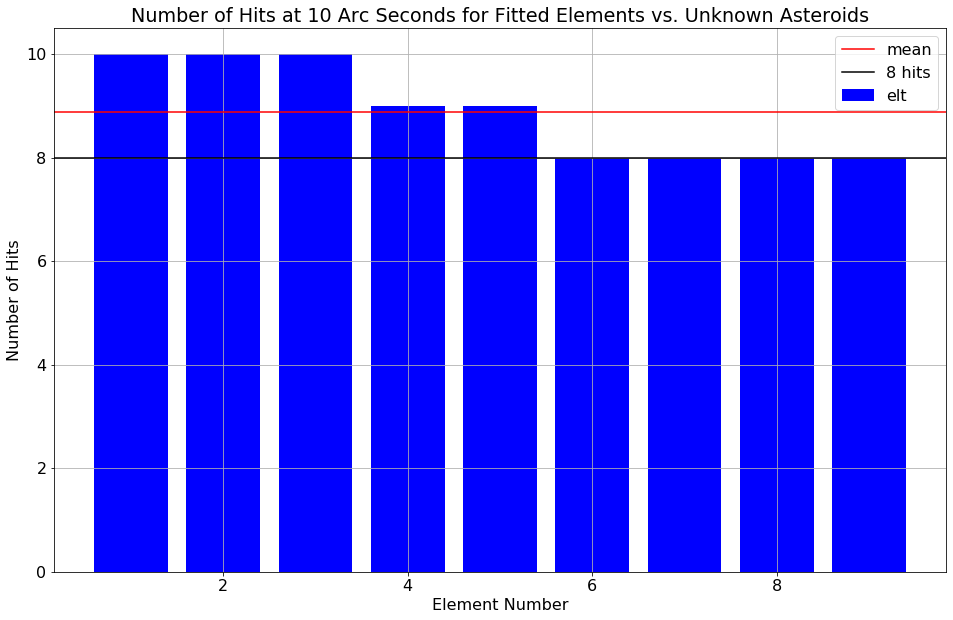

In [43]:
# Plot number of hits
fig_hits, ax = plt.subplots()
ax.set_title('Number of Hits at 10 Arc Seconds for Fitted Elements vs. Unknown Asteroids')
ax.set_xlabel('Element Number')
ax.set_ylabel('Number of Hits')
ax.bar(x=elt_ids, height=hits, label='elt', color='blue')
ax.axhline(y=mean_hits, label='mean', color='red')
ax.axhline(y=ref_hits, label=f'{ref_hits} hits', color='black')
ax.grid()
ax.legend()
plt.show()

In [44]:
fig_hits.savefig('../figs/search_unknown/hits.png', bbox_inches='tight')

In [45]:
# Plot of resolution
log_like = good_elts.log_like
mean_log_like = np.exp(np.mean(np.log(good_elts.log_like)))
ref_log_like = 50.0

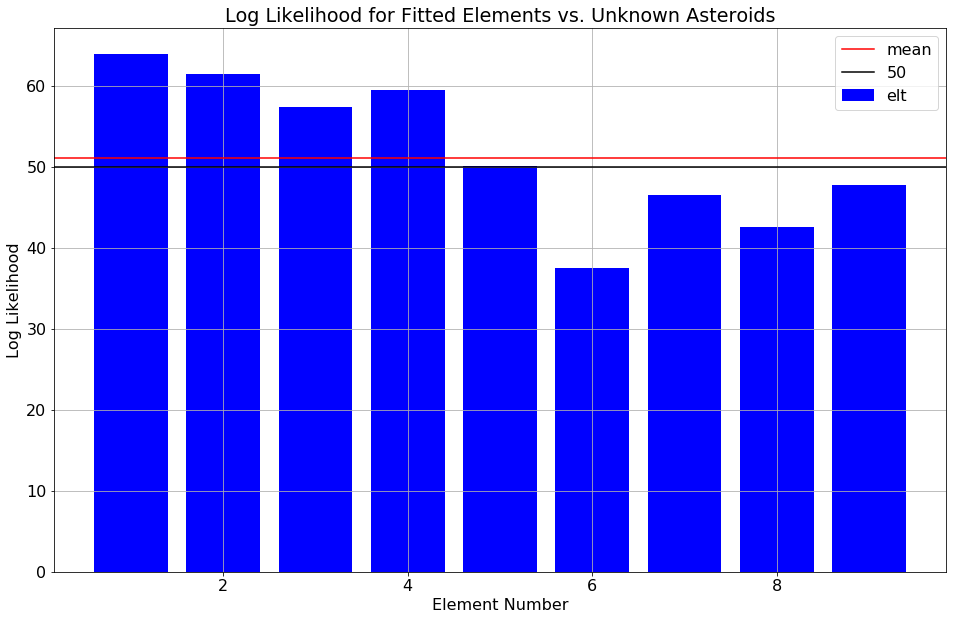

In [46]:
# Plot log likelihood
fig_like, ax = plt.subplots()
ax.set_title('Log Likelihood for Fitted Elements vs. Unknown Asteroids')
ax.set_xlabel('Element Number')
ax.set_ylabel('Log Likelihood')
ax.bar(x=elt_ids, height=log_like, label='elt', color='blue')
ax.axhline(y=mean_log_like, label='mean', color='red')
ax.axhline(y=ref_log_like, label=f'{int(ref_log_like)}', color='black')
ax.grid()
ax.legend()
plt.show()

In [48]:
fig_like.savefig('../figs/search_unknown/log_like.png', bbox_inches='tight')

In [53]:
# Plot of resolution
height_R = 1.0 / good_elts.R_sec
mean_height_R = np.exp(-np.mean(np.log(good_elts.R_sec)))
ref_height_R = 1.0 / 10.0

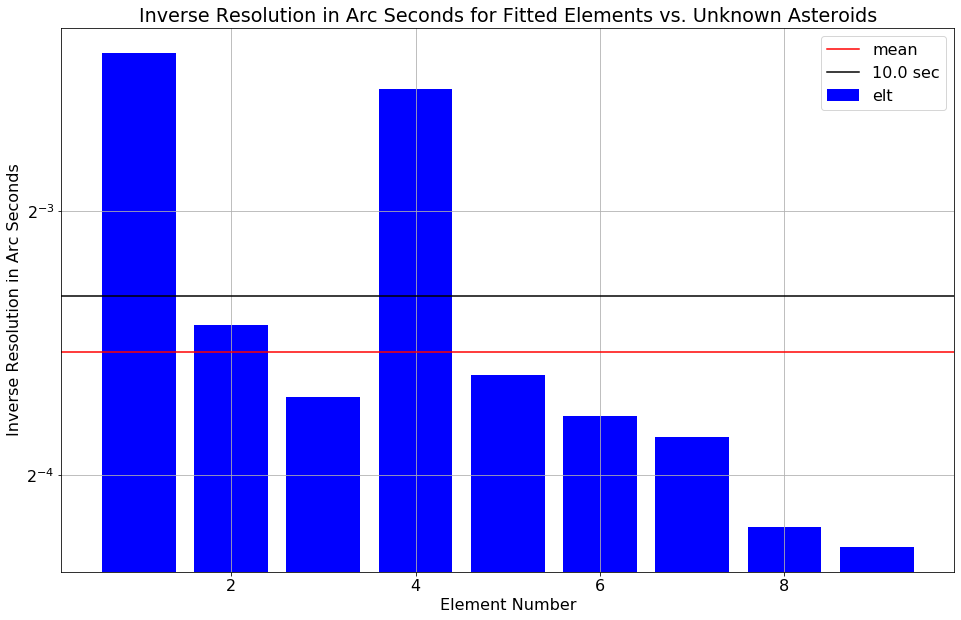

In [56]:
# Plot number of hits
fig_res, ax = plt.subplots()
ax.set_title('Inverse Resolution in Arc Seconds for Fitted Elements vs. Unknown Asteroids')
ax.set_xlabel('Element Number')
ax.set_ylabel('Inverse Resolution in Arc Seconds')
ax.bar(x=elt_ids, height=height_R, label='elt', color='blue')
ax.axhline(y=mean_height_R, label='mean', color='red')
ax.axhline(y=ref_height_R, label=f'10.0 sec', color='black')
ax.set_yscale('log', basey=2)
ax.grid()
ax.legend()
plt.show()

## Nearest Asteroid

In [57]:
near_ast_elt = nearest_ast_elt_cart(elts=good_elts)

In [58]:
q_norm = elt_q_norm(elts=good_elts, ast_num=near_ast_elt.nearest_ast_num)

In [59]:
near_ast_elt['q_norm'] = q_norm

In [60]:
near_ast_elt

,element_id,nearest_ast_num,nearest_ast_name,nearest_ast_dist,a,e,inc,Omega,omega,f,epoch,q_norm
0,170789,1047744,2008 BP24,0.006676,2.737826,0.211857,0.274777,5.970553,3.226452,2.765703,58600.0,1.448192
1,178421,376024,2010 AD87,0.002507,3.160172,0.094590,0.183430,2.464270,4.904836,-0.414887,58600.0,0.701266
2,44117,25765,Heatherlynne,0.007396,2.935316,0.112632,0.034254,2.358439,2.051043,-3.122207,58600.0,2.423549
3,3308,201280,2002 RJ264,0.004533,3.037604,0.103102,0.158730,3.591666,4.605293,-1.127518,58600.0,1.026156
4,45801,1206761,2016 CP279,0.003413,2.762934,0.034538,0.044623,3.268488,5.631680,-1.899197,58600.0,1.622976
5,191915,1141507,2014 HA88,0.003461,2.311171,0.223435,0.056114,1.864166,3.307864,2.077569,58600.0,0.751963
6,113970,1171301,2015 BA199,0.005223,2.876765,0.081095,0.247133,5.613582,3.362128,4.978400,58600.0,1.041216
7,96507,37758,1997 EB36,0.003481,2.816327,0.029105,0.068376,2.175037,1.261131,-2.834449,58600.0,0.804611
8,50775,66350,1999 JS76,0.002726,2.379584,0.099479,0.134353,3.917729,0.165714,2.909787,58600.0,0.940741


In [61]:
geomean_dist = np.exp(np.mean(np.log(near_ast_elt.nearest_ast_dist)))
print(f'Geometric mean distance to nearest asteroid {geomean_dist:6.2e}.')

Geometric mean distance to nearest asteroid 4.10e-03.


In [62]:
# Plot of position diff
height_dist = 1.0 / near_ast_elt.nearest_ast_dist
mean_height_dist = np.exp(np.mean(np.log(height_dist)))
ref_height = 1.0 / 0.001

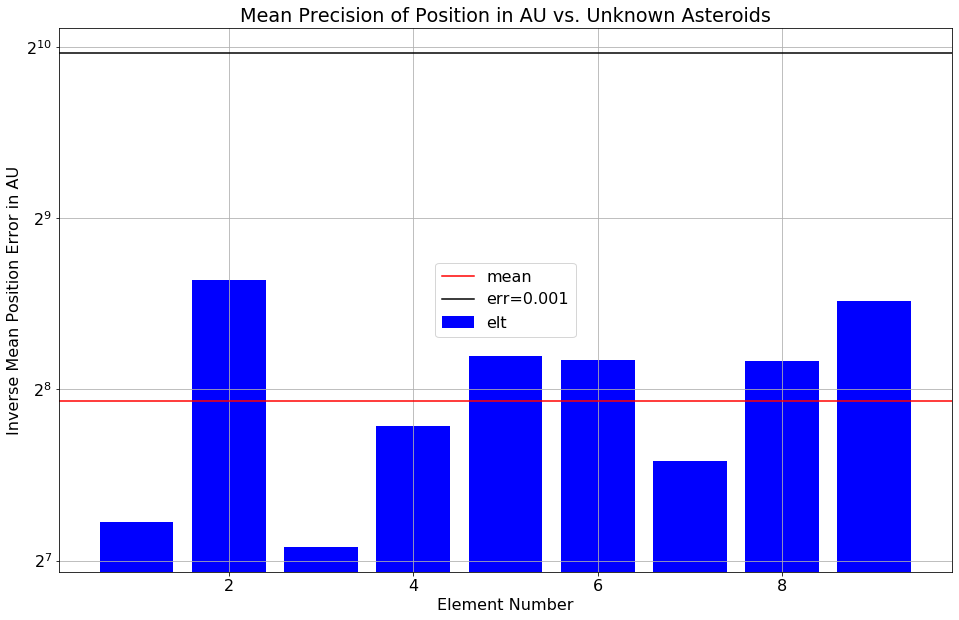

In [66]:
# Plot position error in AU
fig_near_ast, ax = plt.subplots()
ax.set_title('Mean Precision of Position in AU vs. Unknown Asteroids')
ax.set_xlabel('Element Number')
ax.set_ylabel('Inverse Mean Position Error in AU')
ax.bar(x=elt_ids, height=height_dist, label='elt', color='blue')
ax.axhline(y=mean_height_dist, label='mean', color='red')
ax.axhline(y=ref_height, label=f'err=0.001', color='black')
ax.set_yscale('log', basey=2)
ax.grid()
ax.legend()
plt.show()

In [64]:
fig_near_ast.savefig('../figs/search_unknown/near_ast_dist.png', bbox_inches='tight')

In [65]:
# Plot of cov error
height_cov = 1.0 / near_ast_elt.q_norm
mean_height_cov = np.exp(np.mean(np.log(height_cov)))
ref_height_cov = 1.0 / 0.10

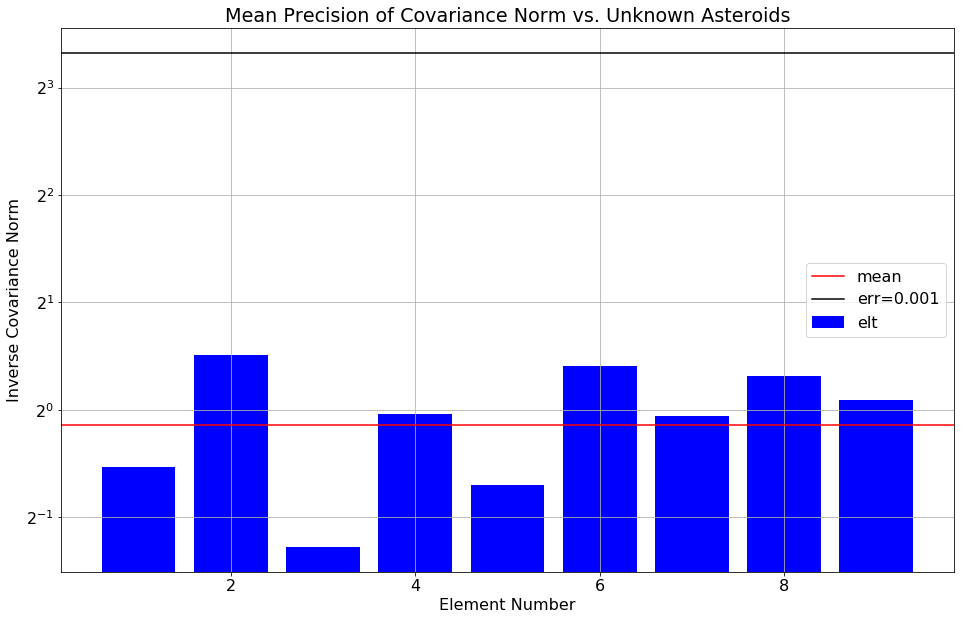

In [67]:
# Plot covariance error
fig_cov, ax = plt.subplots()
ax.set_title('Mean Precision of Covariance Norm vs. Unknown Asteroids')
ax.set_xlabel('Element Number')
ax.set_ylabel('Inverse Covariance Norm')
ax.bar(x=elt_ids, height=height_cov, label='elt', color='blue')
ax.axhline(y=mean_height_cov, label='mean', color='red')
ax.axhline(y=ref_height_cov, label=f'err=0.001', color='black')
ax.set_yscale('log', basey=2)
ax.grid()
ax.legend()
plt.show()

## Load ZTF Data and Batch of Orbital Elements

In [69]:
# Load orbital elements for known asteroids
ast_elt = load_ast_elt()

# Number of asteroids
N_ast = ast_elt.shape[0]

In [70]:
# Parameters to build random orbital elements and ztf_ast
batch_size_init = 1024
batch_size = 64
random_seed = best_element_id // batch_size
thresh_deg = 2.0

In [71]:
# Load ztf nearest asteroid data
ztf_ast = make_ztf_ast(known_ast=known_ast)

In [ ]:
# Review ztf_ast
ztf_ast

In [72]:
ztf_ast.loc[ztf_id_close]

,ztf_id,ObjectID,CandidateID,TimeStampID,mjd,ra,dec,ux,uy,uz,mag_app,asteroid_prob,nearest_ast_num,nearest_ast_dist,ast_ra,ast_dec,ast_ux,ast_uy,ast_uz,is_hit
240776,240776,b'ZTF18abtpdzg',916439883515015003,37432,58670.439884,354.565806,-8.964600,0.983345,-0.147810,-0.105756,17.605200,0.820533,494614,0.003182,354.383563,-8.993565,0.982964,-0.150870,-0.104973,False
240821,240821,b'ZTF18abtpdzg',916440334615015002,37433,58670.440336,354.565888,-8.964426,0.983346,-0.147807,-0.105753,17.601101,0.820533,494614,0.003183,354.383632,-8.993539,0.982964,-0.150869,-0.104973,False
240958,240958,b'ZTF18abtpdzg',916462603515015003,37470,58670.462604,354.565787,-8.964429,0.983346,-0.147809,-0.105753,16.858500,0.820533,494614,0.003120,354.387034,-8.992254,0.982974,-0.150807,-0.104976,False
240991,240991,b'ZTF18abtpdzg',916463054615015001,37471,58670.463056,354.565909,-8.964536,0.983346,-0.147808,-0.105755,17.128700,0.820533,494614,0.003120,354.387103,-8.992228,0.982974,-0.150806,-0.104976,False
241014,241014,b'ZTF18abtpdzg',916462603515015002,37470,58670.462604,354.565824,-8.964445,0.983346,-0.147808,-0.105753,17.092899,0.820533,494614,0.003120,354.387034,-8.992254,0.982974,-0.150807,-0.104976,False
241023,241023,b'ZTF18abtpdzg',916463054615015000,37471,58670.463056,354.565809,-8.964412,0.983346,-0.147808,-0.105753,16.658600,0.820533,494614,0.003119,354.387103,-8.992228,0.982974,-0.150806,-0.104976,False
4384265,4384265,b'ZTF18abspkzw',1109092440215015007,84655,58863.092442,346.642333,1.047626,0.972784,-0.204657,0.108657,16.035000,0.998874,104289,0.001070,346.581753,1.057106,0.972536,-0.205534,0.109218,False
4386577,4386577,b'ZTF18abspkzw',1109110050215015002,84690,58863.110058,346.642277,1.047679,0.972784,-0.204657,0.108659,16.541800,0.998874,104289,0.000970,346.587748,1.058498,0.972560,-0.205431,0.109200,False
4386578,4386578,b'ZTF18abspkzw',1109109605715015000,84689,58863.109606,346.642261,1.047839,0.972784,-0.204656,0.108661,16.946899,0.998874,104289,0.000972,346.587594,1.058462,0.972560,-0.205433,0.109200,False


In [80]:
ztf_hits

element_id   ztf_id         ObjectID          CandidateID  \
element_id ztf_id                                                               
3308       5571214        3308  5571214  b'ZTF17aaaqwwg'  1149113580315015023   
           5571215        3308  5571215  b'ZTF17aaaqwwg'  1149116801415015019   
           5573602        3308  5573602  b'ZTF17aaaqwwg'  1149129091415015026   
           5573603        3308  5573603  b'ZTF17aaaqwwg'  1149126845615015021   
           5574009        3308  5574009  b'ZTF17aaaqwwg'  1149128190315015031   
...                        ...      ...              ...                  ...   
178421     5573603      178421  5573603  b'ZTF17aaaqwwg'  1149126845615015021   
           5574009      178421  5574009  b'ZTF17aaaqwwg'  1149128190315015031   
           5578643      178421  5578643  b'ZTF17aaaqwwg'  1149149241415015027   
           5578644      178421  5578644  b'ZTF17aaaqwwg'  1149149695615015003   
           5579423      178421  5579423  b'ZTF17aaaqwwg'  1149151050315015022   

                             mjd         ra        dec    mag_app        ux  \
element_id ztf_id                                                             
3308       5571214  58903.113588  84.725827  15.284655  19.437901  0.088670   
           5571215  58903.116806  84.725856  15.284678  19.699699  0.088670   
           5573602  58903.129097  84.725897  15.284685  20.146000  0.088669   
           5573603  58903.126840  84.725899  15.284678  19.689501  0.088669   
           5574009  58903.128194  84.725824  15.284668  19.916201  0.088670   
...                          ...        ...        ...        ...       ...   
178421     5573603  58903.126840  84.725899  15.284678  19.689501  0.088669   
           5574009  58903.128194  84.725824  15.284668  19.916201  0.088670   
           5578643  58903.149248  84.726023  15.284693  19.143600  0.088667   
           5578644  58903.149699  84.725870  15.284728  19.707399  0.088669   
           5579423  58903.151053  84.725889  15.284665  19.904301  0.088669   

                          uy        uz    elt_ux    elt_uy    elt_uz  \
element_id ztf_id                                                      
3308       5571214  0.986142 -0.140221  0.088706  0.986137 -0.140231   
           5571215  0.986142 -0.140220  0.088700  0.986138 -0.140229   
           5573602  0.986142 -0.140220  0.088679  0.986141 -0.140223   
           5573603  0.986142 -0.140220  0.088683  0.986140 -0.140224   
           5574009  0.986142 -0.140220  0.088680  0.986141 -0.140223   
...                      ...       ...       ...       ...       ...   
178421     5573603  0.986142 -0.140220  0.088682  0.986140 -0.140226   
           5574009  0.986142 -0.140220  0.088680  0.986140 -0.140224   
           5578643  0.986142 -0.140220  0.088650  0.986147 -0.140200   
           5578644  0.986142 -0.140219  0.088649  0.986147 -0.140199   
           5579423  0.986142 -0.140220  0.088647  0.986147 -0.140198   

                       s_sec                  timestamp  
element_id ztf_id                                        
3308       5571214  7.627845 2020-04-23 22:58:22.891494  
           5571215  6.543056 2020-04-23 22:58:22.891494  
           5573602  2.088163 2020-04-23 22:58:22.891494  
           5573603  2.931724 2020-04-23 22:58:22.891494  
           5574009  2.167005 2020-04-23 22:58:22.891494  
...                      ...                        ...  
178421     5573603  3.047116 2020-04-28 08:06:44.166954  
           5574009  2.289796 2020-04-28 08:06:44.166954  
           5578643  5.501699 2020-04-28 08:06:44.166954  
           5578644  5.926018 2020-04-28 08:06:44.166954  
           5579423  6.569245 2020-04-28 08:06:44.166954  

[78 rows x 16 columns]

In [109]:
good_elts

,element_id,a,e,inc,Omega,omega,f,epoch,num_hits,R_sec,thresh_sec,log_like,hits,num_rows_close,timestamp,nearest_ast_num,nearest_ast_dist,hits_mode_ast_num
element_id,,,,,,,,,,,,,,,,,,
170789,170789,2.735330,0.152867,0.403704,6.038029,3.016818,-3.443415,58600.0,9.997651,5.272874,336.844482,63.894360,10.0,13.0,2020-04-27 15:50:49.486473,1047744,0.006676,494614
178421,178421,3.159712,0.088905,0.153618,2.668798,4.773842,-0.463039,58600.0,10.988490,10.796460,502.733093,61.412579,10.0,19.0,2020-04-28 08:06:44.166954,376024,0.002507,10554
44117,44117,2.935864,0.187419,0.124515,3.166528,1.230836,-3.122138,58600.0,9.990374,13.031281,863.441772,57.351826,10.0,29.0,2020-04-24 20:09:21.720375,25765,0.007396,165747
3308,3308,3.026904,0.119945,0.129432,3.903342,4.525802,4.818909,58600.0,9.921326,5.803865,336.060303,59.502411,9.0,14.0,2020-04-23 22:58:22.891494,201280,0.004533,10554
45801,45801,2.754677,0.047293,0.118126,3.139070,5.767782,-1.949476,58600.0,8.976903,12.320272,589.068054,50.120068,9.0,18.0,2020-04-24 20:53:59.991079,1206761,0.003413,10554
191915,191915,2.315446,0.192885,0.057156,2.130249,2.865086,-4.122024,58600.0,7.974357,13.703813,732.464905,37.517681,8.0,41.0,2020-04-28 07:12:19.739871,1141507,0.003461,1170762
113970,113970,2.897023,0.068932,0.209250,5.663728,3.868474,4.450756,58600.0,7.983499,14.468097,690.245483,46.563499,8.0,14.0,2020-04-26 10:51:54.459207,1171301,0.005223,502631
96507,96507,2.820178,0.069025,0.080228,2.221972,0.960994,-2.630978,58600.0,9.045378,18.369638,750.331299,42.609283,8.0,28.0,2020-04-26 01:52:35.212885,37758,0.003481,148832
50775,50775,2.374712,0.100280,0.165483,4.280114,5.955170,2.995417,58600.0,9.970323,19.354061,862.389160,47.708138,8.0,31.0,2020-04-24 23:35:22.881139,66350,0.002726,10554


In [92]:
good_elts['hits_mode_ast_num'] = 0

In [108]:
for element_id in np.unique(good_elts.element_id):
    ztf_id_close = ztf_hits.ztf_id.loc[element_id].values
    close_ast_num = ztf_ast.nearest_ast_num.loc[ztf_id_close].mode().values[0]
    good_elts['hits_mode_ast_num'].loc[element_id] = close_ast_num

In [ ]:
best_elt - near_elt

## Batches of ZTF Data Near Initial Candidate Elements

In [ ]:
# Arguments to make_ztf_batch
near_ast = False
regenerate = False

In [ ]:
# Load perturbed element batch
ztf_elt = load_ztf_batch(elts=elts, ztf=ztf_ast, thresh_deg=thresh_deg, near_ast=near_ast, regenerate=regenerate)

In [ ]:
# # Review ZTF elements
# ztf_elt

In [ ]:
# Mixture parameters
num_hits: int = 10
R_deg: float = 0.5

In [ ]:
# Add mixture parameters to candidate elements
elts_add_mixture_params(elts=elts, num_hits=num_hits, R_deg=R_deg, thresh_deg=thresh_deg)

In [ ]:
# Add brightness parameter H
elts_add_H(elts=elts)

In [ ]:
# # Review perturbed elements
# elts

## Build Asteroid Search Model

In [ ]:
# Observatory for ZTF data is Palomar Mountain
site_name = 'palomar'

In [ ]:
# Training parameters
learning_rate = 2.0**-12
clipnorm = 1.0

In [ ]:
# The file name for the saved model
file_name = file_name_model(seed=random_seed, known_ast=known_ast, 
                            batch_size_init=batch_size_init, batch_size=batch_size, thresh_deg=thresh_deg)

In [ ]:
# Build asteroid search model
model = AsteroidSearchModel(
                elts=elts, ztf_elt=ztf_elt, 
                site_name=site_name, thresh_deg=thresh_deg, 
                learning_rate=learning_rate, clipnorm=clipnorm,
                name='model',
                file_name=file_name,
)

In [ ]:
# Load trained model
model.load()

In [ ]:
# Report before training starts
model.report()

In [ ]:
# Generate fitted elements
elts_fit = model.candidates_df()

In [ ]:
cols = ['element_id', 'a', 'e', 'inc', 'Omega', 'omega', 'f', 'epoch',
        'num_hits', 'R', 'R_deg', 'R_sec', 'R_max', 'R_deg_max', 'thresh_s',
        'thresh_deg', 'thresh_sec', 'log_like', 'hits', 'num_rows_close']

In [ ]:
# elts_fit[cols]

In [ ]:
# Save ztf_hits to ztf_hits_known_ast or ztf_unknown_ast

In [ ]:
# Generate ZTF hits
ztf_hit = model.calc_ztf_hits()

In [ ]:
# ztf_hit

In [ ]:
elts_fit, elts_near_ast = model.nearest_ast()

In [ ]:
# Review asteroids nearest to the fitted elements
cols = ['element_id', 'log_like', 'hits', 'R_sec', 'thresh_sec', 'nearest_ast_num', 'nearest_ast_dist', 'nearest_ast_q_norm']

# Summary
has_hits = (model.elts_fit.hits >= 5)
is_converged = has_hits
num_converged = np.sum(is_converged)

# Mean on converged
mean_hits = np.mean(model.elts_fit.hits[is_converged])
mean_R_sec = np.mean(model.elts_fit.R_sec[is_converged])
err_cart_mean = np.mean(model.elts_near_ast.nearest_ast_dist[is_converged])
err_cart_geo = np.exp(np.mean(np.log(model.elts_near_ast.nearest_ast_dist[is_converged])))
err_cov_mean = np.exp(np.mean(np.log(model.elts_near_ast.nearest_ast_q_norm[is_converged])))

# Report
print(f'Good convergence on {num_converged} asteroids.')
print(f'Mean on converged asteroids:')
print(f'Number of hits         : {mean_hits:5.2f}')
print(f'Resolution in arc sec  : {mean_R_sec:5.2f}')
print(f'GeoMean Distance in AU : {err_cart_geo:5.2e}')
print(f'Covariance norm        : {err_cov_mean:5.2e}')

In [ ]:
# Review good matches
model.elts_fit[cols][is_converged].sort_values(by=['hits', 'R_sec'], ascending=[False, True])

In [ ]:
from nearest_asteroid import calc_elt_pos, ts

In [ ]:
best_loc = best_element_id % batch_size
elts.loc[best_loc:best_loc]

In [ ]:
q_best_elt = calc_elt_pos(elts.loc[best_loc:best_loc], ts)

In [ ]:
q_near_ast = calc_elt_pos(ast_elt.loc[close_ast_num:close_ast_num], ts)

In [ ]:
mean_dist = np.mean(np.linalg.norm(q_best_elt-q_near_ast, axis=2))
mean_dist

In [ ]:
elt_q_norm(elts.loc[best_loc:best_loc], np.array([close_ast_num]))